In [3]:
import numpy as np # linear algebra
import pandas as pd
import zipfile
import time
import torch
import torchvision as tv
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [4]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [5]:

DATA_DIR = "./data"

with zipfile.ZipFile("facial-keypoints-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [6]:
training_data = pd.read_csv(f'{DATA_DIR}/training.zip')
training_data


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [7]:
X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in training_data["Image"]]
X = np.reshape(X,(-1,96, 96))
X.dtype,X.shape

(dtype('uint8'), (7049, 96, 96))

In [8]:
Y = training_data[["left_eye_center_x","left_eye_center_y"]].values.reshape(-1,2).astype('float32')
Y.dtype,Y.shape

(dtype('float32'), (7049, 2))

In [9]:
Y

array([[66.03356 , 39.002274],
       [64.33294 , 34.970078],
       [65.05705 , 34.90964 ],
       ...,
       [66.690735, 36.845222],
       [70.96508 , 39.853664],
       [66.93831 , 43.42451 ]], dtype=float32)

In [ ]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(X[i], interpolation='nearest',cmap="gray")
    plt.plot(Y[i][0],Y[i][1],marker=".",color="red")
    plt.show()

In [11]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

X2 = []
for i in range(len(X)):
    img = Image.fromarray(X[i]).convert("RGB")
    img = preprocess(img)
    X2.append(np.array(img))

In [12]:
Y2 = Y * (224/96)
Y2.shape

(7049, 2)

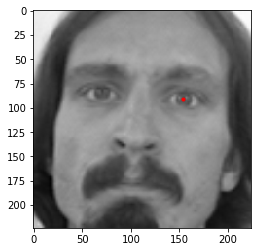

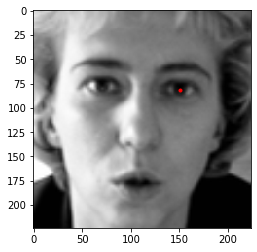

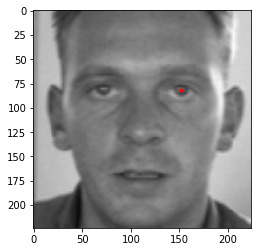

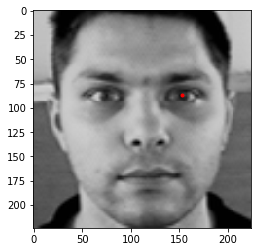

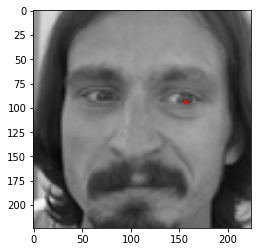

In [13]:
for i in range(5):
    plt.imshow(X2[i].transpose(1,2,0), interpolation='nearest')
    plt.plot(Y2[i][0],Y2[i][1],marker=".",color="red")
    plt.show()

In [14]:
X_Training = np.reshape(X2,(-1, 3, 224, 224))
X_Training.shape

(7049, 3, 224, 224)

In [15]:
import torchvision as tv
import torch.nn as nn

net = tv.models.resnet18(pretrained=True)
net.fc = nn.Linear(512,2)

#Output final architecture
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
#Define Loss
criterion = nn.CrossEntropyLoss()

#Define Optimizer(SGD)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
trainloader = torch.utils.data.DataLoader(list(zip(X_Training,Y2)), batch_size=200, shuffle=True, num_workers=2)

In [ ]:
#Move the input and model to GPU for speed if available
net.to(device)

# Specify the number of epochs for training
num_epochs = 2
batch_size = 40
#Instatiate Logs
running_loss_history = []
running_corrects_history = []
mse = nn.MSELoss()


#Train the net
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in trainloader:
        # setting initial parameter gradients to 0
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)

        loss = mse(output,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print("loss:",loss.item())
        #running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

    epoch_loss = running_loss/len(trainloader) # loss per epoch
    #epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    #running_corrects_history.append(epoch_acc)

    print('Epoch:', epoch)
    print('training loss: {:.4f}'.format(epoch_loss))
